# DeepONet Tutorial in PyTorch

This notebook is a PyTorch reimplementation of a simple 1D DeepONet originally written in JAX/Equinox.
It learns the antiderivative operator from pairs $(u(x), x)$ to $\int_0^x u(s) ds$ using the aligned dataset from DeepXDE.

**What changes vs JAX version**
- Uses `torch.nn` modules for the branch/trunk MLPs and a learnable scalar bias.
- Uses `torch.optim.Adam` with a standard manual training loop.
- Replaces `jax.vmap` with batched tensor operations.
- Keeps plots and evaluation identical where possible.


A DeepONet is a deep learning architecture to evaluate a *nonlinear operator*
applied to a discretized input field/function at an arbitrary query point. This
can, for instance, be used to learn solutions to a family of parametric PDEs
which can then be queried at arbitrary points in space (and time).

Examples of operator mappings:

* From initial condition to solution field at a later time
* From the parameter field (e.g. space-dependent diffusion coefficient) to the
  solution field

The DeepONet does not return the full output field, but allows us to query it at
arbitrary points.

Following the tutorial of
[DeepXDE](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html),
this video is concered with **learning the 1d antiderivative operator**, defined by the ODE

$$
\begin{cases}
\frac{d v}{d x} &= u(x) \quad & x \in [0, 1]
\\
v(0) &= 0
\end{cases}
$$

For this, we discretize the domain $\Omega = [0, 1]$ into $m=100$ degrees of
freedom at which we evaluate $u(x)$. Then, the DeepONet $G_\theta$ takes this
$100$-dimensional vector and a one-dimensional query coordinate to evaluate
$v(x)$ at this query point.

$$
\begin{aligned}
G_\theta : \mathbb{R}^m \times \mathbb{R}^1 \mapsto \mathbb{R}
\end{aligned}
$$

![deeponet_architecture](deeponet_architecture.png)

## Download datasets (from Google Drive) - optional

In [29]:
#Datasets are available at:
train_url = "https://drive.google.com/uc?id=1oLfduzXhmxKUvPJGC-NKkDqN24tVbt16"
val_url   = "https://drive.google.com/uc?id=1HW8dn1DyUpG9EzBZfu3Ocglx67CEi-a4"
test_url  = "https://drive.google.com/uc?id=1-EFfBkvcYG_IasS69_cW_jSk0BokjQEM"
data_url  = "https://drive.google.com/uc?id=1eF71W2q0Wtii4cgoSBw2oL0qdx_2urcD"

In [30]:
# ============================
# Download robusto da Google Drive in E:\progetti\NNDL\Datasets
# ============================
import os, re, numpy as np

# --- CONFIG ---
DATA_DIR = r"E:\progetti\NNDL\Datasets"
os.makedirs(DATA_DIR, exist_ok=True)

load = False  # <--- cambia in False se vuoi saltare il download

train_path = os.path.join(DATA_DIR, "antiderivative_aligned_train.npz")
val_path   = os.path.join(DATA_DIR, "antiderivative_aligned_val.npz")
test_path  = os.path.join(DATA_DIR, "antiderivative_aligned_test.npz")
data_path  = os.path.join(DATA_DIR, "antiderivative_aligned_data.npz")

# --- Helpers ---
def extract_file_id(url_or_id: str) -> str:
    m = re.search(r"(?:id=|/d/)([a-zA-Z0-9_-]{20,})", url_or_id)
    return m.group(1) if m else url_or_id

def download_public(url: str, out: str) -> bool:
    import gdown
    try:
        gdown.download(url, out, quiet=False)
        return os.path.isfile(out)
    except Exception:
        pass
    try:
        gdown.download(url, out, quiet=False, fuzzy=True)
        return os.path.isfile(out)
    except Exception as e:
        print(f"[gdown] Public download fallito per {out}:\n  {e}")
        return False

def download_authenticated(file_id: str, out: str) -> bool:
    try:
        from pydrive2.auth import GoogleAuth
        from pydrive2.drive import GoogleDrive
    except ImportError:
        print("[auth] pydrive2 non installato. Esegui: pip install pydrive2")
        return False
    print("[auth] Avvio autenticazione Google...")
    gauth = GoogleAuth()
    try:
        gauth.LocalWebserverAuth()
    except Exception:
        gauth.CommandLineAuth()
    drive = GoogleDrive(gauth)
    try:
        gfile = drive.CreateFile({'id': file_id})
        gfile.GetContentFile(out)
        return os.path.isfile(out)
    except Exception as e:
        print(f"[auth] Download autenticato fallito per {out}: {e}")
        return False

def robust_get(url_or_id: str, out: str):
    if os.path.isfile(out):
        return
    if download_public(url_or_id, out):
        return
    fid = extract_file_id(url_or_id)
    if not download_authenticated(fid, out):
        raise RuntimeError(f"Impossibile scaricare {out}.")

# --- Scarica tutti i file solo se load=True ---
if load:
    for u, p in [(train_url, train_path), (val_url, val_path), (test_url, test_path), (data_url, data_path)]:
        print(f"[get] {os.path.basename(p)}")
        robust_get(u, p)

# --- Loader aligned ---
def load_split_npz(path: str):
    npz = np.load(path, allow_pickle=True)
    Xb, Xt = npz["X"][0], npz["X"][1]
    y = npz["y"]
    if y.ndim == 2:
        y = y[..., None]
    return dict(Xb=Xb, Xt=Xt, y=y)

train = load_split_npz(train_path)
val   = load_split_npz(val_path)
test  = load_split_npz(test_path)
data  = load_split_npz(data_path)

print("[train]", train["Xb"].shape, train["Xt"].shape, train["y"].shape)
print("[val]",   val["Xb"].shape,   val["Xt"].shape,   val["y"].shape)
print("[test]",  test["Xb"].shape,  test["Xt"].shape,  test["y"].shape)
print("[data]",  data["Xb"].shape,  data["Xt"].shape,  data["y"].shape)

[train] (10500, 1000) (1000, 1) (10500, 1000, 1)
[val] (2250, 1000) (1000, 1) (2250, 1000, 1)
[test] (2250, 1000) (1000, 1) (2250, 1000, 1)
[data] (150, 1000) (1000, 1) (150, 1000, 1)


## Define model

In [31]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
#from tqdm.autonotebook import tqdm
from tqdm import tqdm

# Prefer CUDA if available, else MPS (Apple Silicon), else CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [32]:

# Dataset courtesy of DeepXDE (Lu et al.).
# Original JAX notebook downloaded from ETH Zurich course materials.
# We'll fetch the same training/test sets used there.
#!wget -q -O antiderivative_aligned_train.npz https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_train.npz
#!wget -q -O antiderivative_aligned_test.npz  https://github.com/mroberto166/CAMLab-DLSCTutorials/raw/main/antiderivative_aligned_test.npz

import numpy as np

# Load all splits
train_npz = np.load(os.path.join(DATA_DIR, "antiderivative_aligned_train.npz"), allow_pickle=True)
val_npz   = np.load(os.path.join(DATA_DIR, "antiderivative_aligned_val.npz"), allow_pickle=True)
test_npz  = np.load(os.path.join(DATA_DIR, "antiderivative_aligned_test.npz"), allow_pickle=True)

# --- Training set ---
branch_inputs_train = train_npz["X"][0]   # (N_train, in_size_branch)
trunk_inputs_train  = train_npz["X"][1]   # (N_train, N_grid, 1)
outputs_train       = train_npz["y"]      # (N_train, N_grid, 1)

# --- Validation set ---
branch_inputs_val = val_npz["X"][0]       # (N_val, in_size_branch)
trunk_inputs_val  = val_npz["X"][1]       # (N_val, N_grid, 1)
outputs_val       = val_npz["y"]          # (N_val, N_grid, 1)

# --- Test set ---
branch_inputs_test = test_npz["X"][0]     # (N_test, in_size_branch)
trunk_inputs_test  = test_npz["X"][1]     # (N_test, N_grid, 1)
outputs_test       = test_npz["y"]        # (N_test, N_grid, 1)

# Check shapes
print("Train:", branch_inputs_train.shape, trunk_inputs_train.shape, outputs_train.shape)
print("Val:  ", branch_inputs_val.shape,   trunk_inputs_val.shape,   outputs_val.shape)
print("Test: ", branch_inputs_test.shape,  trunk_inputs_test.shape,  outputs_test.shape)


Train: (10500, 1000) (1000, 1) (10500, 1000)
Val:   (2250, 1000) (1000, 1) (2250, 1000)
Test:  (2250, 1000) (1000, 1) (2250, 1000)


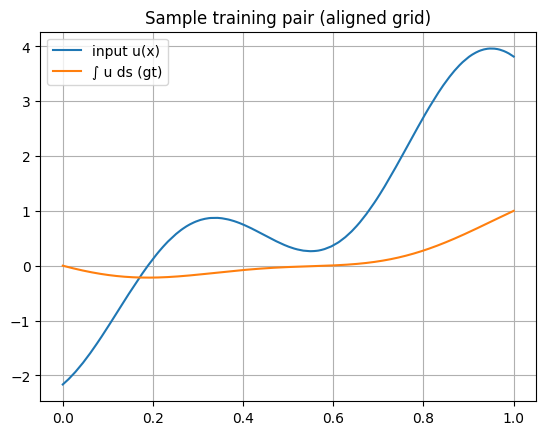

In [33]:

f_idx=0 #index of the function to plot
plt.plot(trunk_inputs_train[:, 0], branch_inputs_train[f_idx, :], label="input u(x)")
plt.plot(trunk_inputs_train[:, 0], outputs_train[f_idx, :], label="∫ u ds (gt)")
plt.grid()
plt.legend()
plt.title("Sample training pair (aligned grid)")
plt.show()


In [34]:
class MLP(nn.Module):
    def __init__(self, in_size, out_size, width_size, depth, activation=nn.ReLU, dropout=0.0):
        super().__init__()
        layers = []
        last = in_size
        for _ in range(depth):
            layers.append(nn.Linear(last, width_size))
            layers.append(activation())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))  # Dropout
            last = width_size
        layers.append(nn.Linear(last, out_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class DeepONet1dSep(nn.Module):
    def __init__(
        self,
        in_size_branch: int,
        interact_size: int,
        branch_width: int = 40,
        branch_depth: int = 2,
        branch_activation: nn.Module = nn.ReLU,
        branch_dropout: float = 0.0,       # <--- aggiunto
        trunk_input_dim: int = 1,
        trunk_width: int = 40,
        trunk_depth: int = 2,
        trunk_activation: nn.Module = nn.Tanh,
        trunk_dropout: float = 0.0,        # <--- aggiunto
    ):
        super().__init__()
        self.branch_net = MLP(
            in_size=in_size_branch,
            out_size=interact_size,
            width_size=branch_width,
            depth=branch_depth,
            activation=branch_activation,
            dropout=branch_dropout
        )
        self.trunk_net = MLP(
            in_size=trunk_input_dim,
            out_size=interact_size,
            width_size=trunk_width,
            depth=trunk_depth,
            activation=trunk_activation,
            dropout=trunk_dropout
        )
        self.bias = nn.Parameter(torch.zeros(1))


    def forward(self, x_branch, x_trunk):
        """
        x_branch: (B, P) or (P,)
        x_trunk:  (N,1) or (B, N) or (B, N, 1)
        returns:  (B, N, 1) or (N, 1) if single-sample
        """
        single_sample = False
        if x_branch.dim() == 1:
            x_branch = x_branch.unsqueeze(0)  # (1, P)
            single_sample = True

        # Normalize x_trunk to (B, N, 1)
        if x_trunk.dim() == 1:
            x_trunk = x_trunk.unsqueeze(-1)                # (N,) -> (N,1)
        if x_trunk.dim() == 2:
            if x_trunk.size(-1) != 1:                      # (B,N) -> (B,N,1)
                x_trunk = x_trunk.unsqueeze(-1)
            else:                                          # (N,1) -> (B,N,1)
                x_trunk = x_trunk.unsqueeze(0).expand(x_branch.size(0), -1, -1)
        elif x_trunk.dim() == 3 and x_trunk.size(0) == 1 and x_branch.size(0) > 1:
            x_trunk = x_trunk.expand(x_branch.size(0), -1, -1)

        B, N, _ = x_trunk.shape
        bfeat = self.branch_net(x_branch)                        # (B, P')
        tfeat = self.trunk_net(x_trunk.reshape(B * N, -1))       # (B*N, P')
        tfeat = tfeat.view(B, N, -1)                             # (B, N, P')
        out = (bfeat.unsqueeze(1) * tfeat).sum(dim=-1, keepdim=True) + self.bias.view(1, 1, 1)
        if single_sample:
            out = out.squeeze(0)  # (N,1)
        return out


## Hyperparameter optimization

In [7]:
#Version without validation
"""
import torch
import optuna
import torch.optim as optim
from torch import nn
from tqdm import tqdm  # Import tqdm for progress bar

# Ensure your training and testing data are loaded here
# Example (adjust as needed based on your dataset):
Xb_train = torch.tensor(branch_inputs_train, dtype=torch.float32, device=device)  # (N_train, in_size_branch)
Xt_train = torch.tensor(trunk_inputs_train,  dtype=torch.float32, device=device)  # (N_train, N_grid, 1)
Y_train = torch.tensor(outputs_train, dtype=torch.float32, device=device)  # (N_train, N_grid, 1)

Xb_test = torch.tensor(branch_inputs_test, dtype=torch.float32, device=device)  # (N_test, in_size_branch)
Xt_test = torch.tensor(trunk_inputs_test,  dtype=torch.float32, device=device)  # (N_test, N_grid, 1)
Y_test = torch.tensor(outputs_test, dtype=torch.float32, device=device)  # (N_test, N_grid, 1)

# Ensure Y_train and Y_test have the shape (B, N, 1)
if Y_train.dim() == 2:
    Y_train = Y_train.unsqueeze(-1)  # (N_train, N_grid) -> (N_train, N_grid, 1)
if Y_test.dim() == 2:
    Y_test = Y_test.unsqueeze(-1)  # (N_test, N_grid) -> (N_test, N_grid, 1)

# Define the objective function for Optuna's optimization
def objective(trial: optuna.Trial):
    # Altri iperparametri già presenti...
    dropout_branch = trial.suggest_float("dropout_branch", 0.0, 0.5)
    dropout_trunk  = trial.suggest_float("dropout_trunk", 0.0, 0.5)

    # Model setup
    model = DeepONet1dSep(
        in_size_branch=Xb_train.shape[1],
        interact_size=trial.suggest_int("interact_size", 5, 100, step=30),
        branch_width=trial.suggest_int("branch_width", 10, 200, step=30),
        branch_depth=trial.suggest_int("branch_depth", 1, 5),
        branch_activation=trial.suggest_categorical("branch_activation", [nn.ReLU, nn.Tanh, nn.GELU]),
        branch_dropout=dropout_branch,  # <--- aggiunto
        trunk_input_dim=1,
        trunk_width=trial.suggest_int("trunk_width", 10, 200, step=30),
        trunk_depth=trial.suggest_int("trunk_depth", 1, 5),
        trunk_activation=trial.suggest_categorical("trunk_activation", [nn.ReLU, nn.Tanh, nn.GELU]),
        trunk_dropout=dropout_trunk     # <--- aggiunto
    ).to(device)

    # Ottimizzatore con L2
    optimizer = optim.Adam(
        model.parameters(),
        lr=trial.suggest_loguniform("learning_rate", 1e-5, 1e-2),
        weight_decay=trial.suggest_loguniform("l2_reg_strength", 1e-5, 1e-2)
    )

    # Training loop
    model.train()
    num_epochs = 10
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(Xb_train, Xt_train)
        loss = torch.mean((outputs - Y_train)**2)
        loss.backward()
        optimizer.step()

    # Validation MSE
    model.eval()
    with torch.no_grad():
        Y_pred = model(Xb_test, Xt_test)
        mse = torch.mean((Y_pred - Y_test)**2).item()

    return mse

# Create Optuna study and optimize the objective function with a tqdm progress bar for the entire optimization process
study = optuna.create_study(direction="minimize")

# Use tqdm for overall progress bar across all trials
n_trials = 5000
with tqdm(total=n_trials, desc="Overall Optimization Progress", position=0, leave=True) as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)  # Update the progress bar after each trial

    # You can resume optimization if there is a stored study
    study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback])

# Save the best parameters found
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Save best parameters to a file
import pickle
with open("best_params.pkl", "wb") as f:
    pickle.dump(best_params, f)
"""

'\nimport torch\nimport optuna\nimport torch.optim as optim\nfrom torch import nn\nfrom tqdm import tqdm  # Import tqdm for progress bar\n\n# Ensure your training and testing data are loaded here\n# Example (adjust as needed based on your dataset):\nXb_train = torch.tensor(branch_inputs_train, dtype=torch.float32, device=device)  # (N_train, in_size_branch)\nXt_train = torch.tensor(trunk_inputs_train,  dtype=torch.float32, device=device)  # (N_train, N_grid, 1)\nY_train = torch.tensor(outputs_train, dtype=torch.float32, device=device)  # (N_train, N_grid, 1)\n\nXb_test = torch.tensor(branch_inputs_test, dtype=torch.float32, device=device)  # (N_test, in_size_branch)\nXt_test = torch.tensor(trunk_inputs_test,  dtype=torch.float32, device=device)  # (N_test, N_grid, 1)\nY_test = torch.tensor(outputs_test, dtype=torch.float32, device=device)  # (N_test, N_grid, 1)\n\n# Ensure Y_train and Y_test have the shape (B, N, 1)\nif Y_train.dim() == 2:\n    Y_train = Y_train.unsqueeze(-1)  # (N_tra

In [37]:
import os, pickle, math
import torch
import optuna
import torch.optim as optim
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

# --- Debug vs velocità ---
os.environ.setdefault("CUDA_LAUNCH_BLOCKING", "1")  # "0" se non ti servono stack CUDA
torch.backends.cudnn.benchmark = True               # True = più veloce se le shape sono fisse

# --- Device ---
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# ==================== LOAD (CPU) ====================
Xb_train = torch.tensor(branch_inputs_train, dtype=torch.float32).contiguous()
Xt_train = torch.tensor(trunk_inputs_train,  dtype=torch.float32).contiguous()
Y_train  = torch.tensor(outputs_train,       dtype=torch.float32).contiguous()

Xb_val   = torch.tensor(branch_inputs_val,   dtype=torch.float32).contiguous()
Xt_val   = torch.tensor(trunk_inputs_val,    dtype=torch.float32).contiguous()
Y_val    = torch.tensor(outputs_val,         dtype=torch.float32).contiguous()

Xb_test  = torch.tensor(branch_inputs_test,  dtype=torch.float32).contiguous()
Xt_test  = torch.tensor(trunk_inputs_test,   dtype=torch.float32).contiguous()
Y_test   = torch.tensor(outputs_test,        dtype=torch.float32).contiguous()

# ==================== SHAPE FIX (Y -> (B,N,1), Xt -> (B,N,1)) ====================
def _assert_finite(name, t):
    if not torch.isfinite(t).all():
        raise ValueError(f"[DATA] Non-finite values in {name}.")

def _ensure_Y_3d(Y):
    # target: (B, N, 1)
    if Y.dim() == 2:
        Y = Y.unsqueeze(-1)  # (B,N) -> (B,N,1)
    assert Y.dim() == 3 and Y.size(-1) == 1, f"Y must be (B,N,1), got {tuple(Y.shape)}"
    return Y

def _make_Xt_3d(Xt, B_target, N_target):
    """
    Converte Xt in (B, N, 1) gestendo casi tipici:
      - (B,N,1) -> ok
      - (B,1) o (B,1,1) -> ripeti su N
      - (N,) o (N,1) -> tiling su B
      - (B*N,1) o (B*N,1,1) -> reshape a (B,N,1)
    """
    # già ok
    if Xt.dim() == 3 and Xt.size(0) == B_target and Xt.size(1) == N_target and Xt.size(2) == 1:
        return Xt
    # (B,1) -> (B,N,1)
    if Xt.dim() == 2 and Xt.size(0) == B_target and Xt.size(1) == 1:
        return Xt.unsqueeze(1).repeat(1, N_target, 1)
    # (B,1,1) -> (B,N,1)
    if Xt.dim() == 3 and Xt.size(0) == B_target and Xt.size(1) == 1 and Xt.size(2) == 1:
        return Xt.repeat(1, N_target, 1)
    # (N,) -> (B,N,1)
    if Xt.dim() == 1 and Xt.size(0) == N_target:
        return Xt.view(1, N_target, 1).repeat(B_target, 1, 1)
    # (N,1) -> (B,N,1)
    if Xt.dim() == 2 and Xt.size(0) == N_target and Xt.size(1) == 1:
        return Xt.unsqueeze(0).repeat(B_target, 1, 1)
    # (B*N,1) -> (B,N,1)
    if Xt.dim() == 2 and Xt.size(0) == B_target * N_target and Xt.size(1) == 1:
        return Xt.view(B_target, N_target, 1)
    # (B*N,1,1) -> (B,N,1)
    if Xt.dim() == 3 and Xt.size(0) == B_target * N_target and Xt.size(1) == 1 and Xt.size(2) == 1:
        return Xt.view(B_target, N_target, 1)
    raise AssertionError(f"Xt shape {tuple(Xt.shape)} non compatibile con (B={B_target}, N={N_target}, 1).")

# finite check
for name, t in [("Xb_train", Xb_train), ("Xt_train", Xt_train), ("Y_train", Y_train),
                ("Xb_val", Xb_val), ("Xt_val", Xt_val), ("Y_val", Y_val),
                ("Xb_test", Xb_test), ("Xt_test", Xt_test), ("Y_test", Y_test)]:
    _assert_finite(name, t)

# Y -> (B,N,1)
Y_train = _ensure_Y_3d(Y_train).contiguous()
Y_val   = _ensure_Y_3d(Y_val).contiguous()
Y_test  = _ensure_Y_3d(Y_test).contiguous()

# Coerenza B (se fallisce, gli split non sono stati fatti con gli stessi indici)
assert Xb_train.size(0) == Y_train.size(0), f"[TRAIN] B mismatch: Xb={Xb_train.size(0)} vs Y={Y_train.size(0)}"
assert Xb_val.size(0)   == Y_val.size(0),   f"[VAL]   B mismatch: Xb={Xb_val.size(0)} vs Y={Y_val.size(0)}"
assert Xb_test.size(0)  == Y_test.size(0),  f"[TEST]  B mismatch: Xb={Xb_test.size(0)} vs Y={Y_test.size(0)}"

# Xt -> (B,N,1)
N_tr, N_vl, N_ts = Y_train.size(1), Y_val.size(1), Y_test.size(1)
Xt_train = _make_Xt_3d(Xt_train, Xb_train.size(0), N_tr).contiguous()
Xt_val   = _make_Xt_3d(Xt_val,   Xb_val.size(0),   N_vl).contiguous()
Xt_test  = _make_Xt_3d(Xt_test,  Xb_test.size(0),  N_ts).contiguous()

print("[SHAPES] Train:", tuple(Xb_train.shape), tuple(Xt_train.shape), tuple(Y_train.shape))
print("[SHAPES] Val:  ", tuple(Xb_val.shape),   tuple(Xt_val.shape),   tuple(Y_val.shape))
print("[SHAPES] Test: ", tuple(Xb_test.shape),  tuple(Xt_test.shape),  tuple(Y_test.shape))

# ==================== DATALOADERS (CPU -> device nel loop) ====================
class TwoInputDataset(Dataset):
    def __init__(self, xb, xt, y):
        assert xb.size(0) == xt.size(0) == y.size(0), \
            f"B mismatch: Xb={xb.size(0)}, Xt={xt.size(0)}, Y={y.size(0)}"
        self.xb, self.xt, self.y = xb, xt, y
    def __len__(self): return self.y.size(0)
    def __getitem__(self, idx): return self.xb[idx], self.xt[idx], self.y[idx]

batch_size = 256           # riduci se serve VRAM
num_workers = 0            # Windows/Jupyter -> 0
pin_mem = (device.type == "cuda")

train_loader = DataLoader(TwoInputDataset(Xb_train, Xt_train, Y_train),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(TwoInputDataset(Xb_val, Xt_val, Y_val),
                          batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_mem)

# ==================== AMP (senza FutureWarning) ====================
USE_BF16  = (device.type == "cuda" and torch.cuda.is_bf16_supported())
AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16
use_amp   = (device.type == "cuda")
scaler    = torch.amp.GradScaler("cuda", enabled=(use_amp and not USE_BF16))
mse_loss  = nn.MSELoss()
grad_accum_steps = 1

def _run_train_val_once(model, optimizer, dev):
    model.train()
    running = 0.0
    optimizer.zero_grad(set_to_none=True)

    for step, (xb, xt, yy) in enumerate(train_loader, start=1):
        xb = xb.to(dev, non_blocking=True).contiguous()
        xt = xt.to(dev, non_blocking=True).contiguous()
        yy = yy.to(dev, non_blocking=True).contiguous()

        with torch.autocast(device_type=("cuda" if dev.type=="cuda" else "cpu"),
                            dtype=AMP_DTYPE, enabled=use_amp):
            pred = model(xb, xt)
            if pred.shape != yy.shape:
                raise RuntimeError(f"[SHAPE] pred {pred.shape} vs Y {yy.shape}")
            loss = mse_loss(pred, yy) / grad_accum_steps

        if scaler.is_enabled():
            scaler.scale(loss).backward()
        else:
            loss.backward()

        if step % grad_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            if scaler.is_enabled():
                scaler.step(optimizer); scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        running += loss.item() * grad_accum_steps

    train_loss_epoch = running / max(1, len(train_loader))

    # ---- Val ----
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for xb, xt, yy in val_loader:
            xb = xb.to(dev, non_blocking=True).contiguous()
            xt = xt.to(dev, non_blocking=True).contiguous()
            yy = yy.to(dev, non_blocking=True).contiguous()
            with torch.autocast(device_type=("cuda" if dev.type=="cuda" else "cpu"),
                                dtype=AMP_DTYPE, enabled=use_amp):
                pv = model(xb, xt)
                if pv.shape != yy.shape:
                    raise RuntimeError(f"[SHAPE] val pred {pv.shape} vs Y {yy.shape}")
                vloss = mse_loss(pv, yy)
            val_running += float(vloss.item())

    val_loss_epoch = val_running / max(1, len(val_loader))
    return float(train_loss_epoch), float(val_loss_epoch)

# ==================== OPTUNA (epoche corte; niente torch.compile se Triton manca) ====================
_ACT_NAMES = ("relu", "tanh", "gelu")
def _act_from_name(name: str):
    return {"relu": nn.ReLU, "tanh": nn.Tanh, "gelu": nn.GELU}[name]

def objective(trial: optuna.Trial):
    interact_size  = trial.suggest_int("interact_size", 5, 95, step=30)
    branch_width   = trial.suggest_int("branch_width", 10, 190, step=30)
    branch_depth   = trial.suggest_int("branch_depth", 1, 5)
    trunk_width    = trial.suggest_int("trunk_width", 10, 190, step=30)
    trunk_depth    = trial.suggest_int("trunk_depth", 1, 5)
    branch_act_n   = trial.suggest_categorical("branch_activation", _ACT_NAMES)
    trunk_act_n    = trial.suggest_categorical("trunk_activation",  _ACT_NAMES)
    dropout_branch = trial.suggest_float("dropout_branch", 0.0, 0.5)
    dropout_trunk  = trial.suggest_float("dropout_trunk",  0.0, 0.5)
    lr             = trial.suggest_float("learning_rate", 1e-4, 3e-3, log=True)
    l2             = trial.suggest_float("l2_reg_strength", 1e-6, 1e-3, log=True)

    branch_act = _act_from_name(branch_act_n)
    trunk_act  = _act_from_name(trunk_act_n)

    model = DeepONet1dSep(
        in_size_branch=Xb_train.shape[1],
        interact_size=interact_size,
        branch_width=branch_width,
        branch_depth=branch_depth,
        branch_activation=branch_act,
        branch_dropout=dropout_branch,
        trunk_input_dim=1,
        trunk_width=trunk_width,
        trunk_depth=trunk_depth,
        trunk_activation=trunk_act,
        trunk_dropout=dropout_trunk
    ).to(device).float()

    # Usa torch.compile solo se Triton è disponibile (evita BackendCompilerFailed su Windows)
    USE_COMPILE = False
    if hasattr(torch, "compile") and device.type == "cuda":
        try:
            import triton  # noqa: F401
            USE_COMPILE = True
        except Exception:
            USE_COMPILE = False
    if USE_COMPILE:
        try:
            model = torch.compile(model)
        except Exception:
            pass  # fallback al modo eager

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

    num_epochs = 20
    patience   = 5
    best_val = float("inf")
    bad = 0

    for epoch in range(num_epochs):
        train_loss, val_loss = _run_train_val_once(model, optimizer, device)
        trial.report(val_loss, step=epoch)  # report needed for pruning

        # ---- pruning check (gentle) ----
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val - 1e-7:
            best_val = val_loss; bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

        scheduler.step(val_loss)

    return best_val
    
######################################## Trial
"""
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.NopPruner()) #with pruning
"""
# ===== Persistent Optuna study (resume with load=True) =====
from pathlib import Path
import optuna

# ---- choose pruner (gentle) ----
PRUNER = optuna.pruners.MedianPruner(
    n_startup_trials=15,   # let enough trials run unpruned
    n_warmup_steps=8,      # epochs before using intermediate values
    interval_steps=2       # check every 2 epochs
)

def get_study(*, load: bool, study_name: str = "deeponet_v1", db_path: str = "deeponet_v1.db", pruner=None):
    storage_url = f"sqlite:///{db_path}"
    if pruner is None:
        pruner = optuna.pruners.NopPruner()  # default fallback

    if load:
        try:
            study = optuna.load_study(study_name=study_name, storage=storage_url, pruner=pruner)
            print(f"[Optuna] Loaded existing study '{study_name}' from {db_path}")
        except KeyError:
            study = optuna.create_study(
                direction="minimize",
                study_name=study_name,
                storage=storage_url,
                load_if_exists=True,
                pruner=pruner,
            )
            print(f"[Optuna] Created new study '{study_name}' in {db_path}")
    else:
        p = Path(db_path)
        if p.exists():
            p.unlink()
            print(f"[Optuna] Removed previous DB at {db_path}")
        study = optuna.create_study(
            direction="minimize",
            study_name=study_name,
            storage=storage_url,
            load_if_exists=False,
            pruner=pruner,
        )
        print(f"[Optuna] Created NEW study '{study_name}' in {db_path}")
    return study

# choose here
LOAD_STUDY = True   # set False to start fresh
STUDY_NAME = "deeponet_v2"
DB_PATH    = "deeponet_v2.db"

study = get_study(load=LOAD_STUDY, study_name=STUDY_NAME, db_path=DB_PATH, pruner=PRUNER)
########################################



n_trials = 500
with tqdm(total=n_trials, desc="Overall Optimization Progress", position=0, leave=True) as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)
    study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback], catch=(Exception,))

best_params = study.best_params
print(f"Best parameters: {best_params}")

with open("best_params.pkl", "wb") as f:
    pickle.dump(best_params, f)

[SHAPES] Train: (10500, 1000) (10500, 1000, 1) (10500, 1000, 1)
[SHAPES] Val:   (2250, 1000) (2250, 1000, 1) (2250, 1000, 1)
[SHAPES] Test:  (2250, 1000) (2250, 1000, 1) (2250, 1000, 1)


KeyboardInterrupt: 

## Training

## Opzione 1: training su training set + validation set per early stopping

## Opzione 2: training su training + validation set

Best params: {'interact_size': 65, 'branch_width': 160, 'branch_depth': 1, 'trunk_width': 190, 'trunk_depth': 5, 'branch_activation': 'relu', 'trunk_activation': 'relu', 'dropout_branch': 0.00020445520765750678, 'dropout_trunk': 0.00586806401581335, 'learning_rate': 0.0021472135707765764, 'l2_reg_strength': 2.0780775148995858e-05}
Xb_tr      -> (10500, 1000)
Xt_tr      -> (10500, 1000, 1)
Y_tr       -> (10500, 1000, 1)
Xb_va      -> (2250, 1000)
Xt_va      -> (2250, 1000, 1)
Y_va       -> (2250, 1000, 1)
Xb_full    -> (12750, 1000)
Xt_full    -> (12750, 1000, 1)
Y_full     -> (12750, 1000, 1)


Final training (train+val, mini-batch): 100%|████████████████████████████████████████| 500/500 [32:51<00:00,  3.94s/it]


Modello finale salvato in 'final_model_train_plus_val_minibatch.pt'


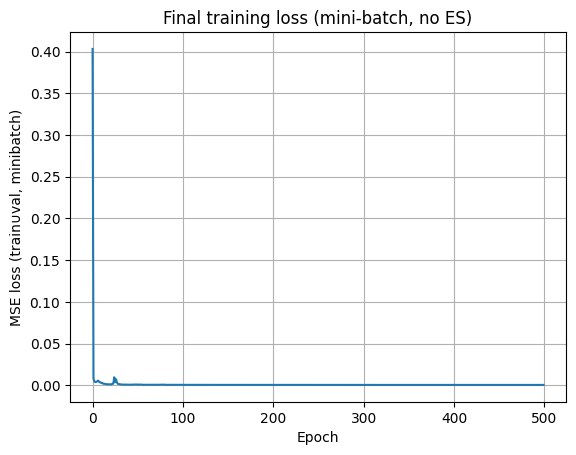

Test MSE (final model trained on train+val, minibatch): 0.000221


In [25]:
import pickle
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------- 1) Carica i best params scelti su validation ----------
with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)
print("Best params:", best_params)

# (handle activations saved as strings)
def _act_from_any(v):
    if isinstance(v, str):
        m = {"relu": nn.ReLU, "tanh": nn.Tanh, "gelu": nn.GELU}
        lv = v.lower()
        if lv in m: return m[lv]
    return v  # already a class/type

# ---------- 2) Prepara tensori: unisci TRAIN e VAL ----------
# NOTE: keep tensors on CPU; we'll move to device per-batch in the loop
Xb_tr = torch.tensor(branch_inputs_train, dtype=torch.float32)
Xt_tr = torch.tensor(trunk_inputs_train,  dtype=torch.float32)
Y_tr  = torch.tensor(outputs_train,       dtype=torch.float32)

Xb_va = torch.tensor(branch_inputs_val,   dtype=torch.float32)
Xt_va = torch.tensor(trunk_inputs_val,    dtype=torch.float32)
Y_va  = torch.tensor(outputs_val,         dtype=torch.float32)

# Assicura shape target (B, N, 1) per Y_tr/Y_va
if Y_tr.dim() == 2: Y_tr = Y_tr.unsqueeze(-1)
if Y_va.dim() == 2: Y_va = Y_va.unsqueeze(-1)

# Helper per portare Xt a (B, N, 1) nei casi comuni
def _make_Xt_3d(Xt, B_target, N_target):
    if Xt.dim() == 3 and Xt.size(0) == B_target and Xt.size(1) == N_target and Xt.size(2) == 1:
        return Xt
    if Xt.dim() == 2 and Xt.size(0) == B_target and Xt.size(1) == 1:
        return Xt.unsqueeze(1).repeat(1, N_target, 1)
    if Xt.dim() == 3 and Xt.size(0) == B_target and Xt.size(1) == 1 and Xt.size(2) == 1:
        return Xt.repeat(1, N_target, 1)
    if Xt.dim() == 1 and Xt.size(0) == N_target:
        return Xt.view(1, N_target, 1).repeat(B_target, 1, 1)
    if Xt.dim() == 2 and Xt.size(0) == N_target and Xt.size(1) == 1:
        return Xt.unsqueeze(0).repeat(B_target, 1, 1)
    if Xt.dim() == 2 and Xt.size(0) == B_target * N_target and Xt.size(1) == 1:
        return Xt.view(B_target, N_target, 1)
    if Xt.dim() == 3 and Xt.size(0) == B_target * N_target and Xt.size(1) == 1 and Xt.size(2) == 1:
        return Xt.view(B_target, N_target, 1)
    raise AssertionError(f"Xt shape {tuple(Xt.shape)} non compatibile con (B={B_target}, N={N_target}, 1).")

# Porta Xt_tr/Xt_va a (B, N, 1) PRIMA di concatenare
Xt_tr = _make_Xt_3d(Xt_tr, Xb_tr.size(0), Y_tr.size(1)).contiguous()
Xt_va = _make_Xt_3d(Xt_va, Xb_va.size(0), Y_va.size(1)).contiguous()

# concatena lungo la dimensione batch
Xb_full = torch.cat([Xb_tr, Xb_va], dim=0).contiguous()
Xt_full = torch.cat([Xt_tr, Xt_va], dim=0).contiguous()
Y_full  = torch.cat([Y_tr,  Y_va ], dim=0).contiguous()

# Assicura shape target (B, N, 1) per Y_full
if Y_full.dim() == 2:
    Y_full = Y_full.unsqueeze(-1)

# Test set (CPU) + shape fix
Xb_te = torch.tensor(branch_inputs_test, dtype=torch.float32)
Xt_te = torch.tensor(trunk_inputs_test,  dtype=torch.float32)
Y_te  = torch.tensor(outputs_test,       dtype=torch.float32)
if Y_te.dim() == 2:
    Y_te = Y_te.unsqueeze(-1)
Xt_te = _make_Xt_3d(Xt_te, Xb_te.size(0), Y_te.size(1)).contiguous()

##################################
def shape(name, t):
    print(f"{name:10s} -> {tuple(t.shape)}")

shape("Xb_tr", Xb_tr); shape("Xt_tr", Xt_tr); shape("Y_tr",  Y_tr)
shape("Xb_va", Xb_va); shape("Xt_va", Xt_va); shape("Y_va",  Y_va)
shape("Xb_full", Xb_full); shape("Xt_full", Xt_full); shape("Y_full",  Y_full)

# Verifica B uguali sulle tre
Bxb, Bxt, By = Xb_full.size(0), Xt_full.size(0), Y_full.size(0)
assert Bxb == Bxt == By, f"Batch mismatch: Xb={Bxb}, Xt={Bxt}, Y={By}"
#######################################################################

# ---------- 3) DataLoader (mini-batch; CPU tensors, pin if cuda) ----------
batch_size = 256  # puoi provare 128/256 se la GPU lo permette ############################## Control mini-batch size
pin_mem = (device.type == "cuda")
dataset = TensorDataset(Xb_full, Xt_full, Y_full)
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                     drop_last=False, pin_memory=pin_mem, num_workers=0)

# ---------- 4) Modello con i best params ----------
model = DeepONet1dSep(
    in_size_branch=Xb_full.shape[1],
    interact_size=best_params["interact_size"],
    branch_width=best_params["branch_width"],
    branch_depth=best_params["branch_depth"],
    branch_activation=_act_from_any(best_params["branch_activation"]),
    branch_dropout=best_params["dropout_branch"],
    trunk_input_dim=1,
    trunk_width=best_params["trunk_width"],
    trunk_depth=best_params["trunk_depth"],
    trunk_activation=_act_from_any(best_params["trunk_activation"]),
    trunk_dropout=best_params["dropout_trunk"]
).to(device).float()

loss_fn   = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),
                       lr=best_params["learning_rate"],
                       weight_decay=best_params["l2_reg_strength"])

# Facoltativo: riduci LR se la loss media d'epoca non scende
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                 factor=0.5, patience=10, verbose=False)

# ---------- 5) Training (20k epoche, NO early stopping) ----------
max_epochs = 500
epoch_losses = []

for epoch in tqdm(range(1, max_epochs + 1), desc="Final training (train+val, mini-batch)"):
    model.train()
    running = 0.0
    count   = 0

    for xb, xt, yy in loader:
        # move batch to device here
        xb = xb.to(device, non_blocking=True)
        xt = xt.to(device, non_blocking=True)
        yy = yy.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        pred = model(xb, xt)          # (B, N, 1)
        loss = loss_fn(pred, yy)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running += float(loss.detach().cpu())
        count   += 1

    # loss media per epoca
    epoch_loss = running / max(1, count)
    epoch_losses.append(epoch_loss)

    # scheduler (opzionale)
    scheduler.step(epoch_loss)

# Salva i pesi finali dopo 20k epoche
torch.save(model.state_dict(), "final_model_train_plus_val_minibatch.pt")
print("Modello finale salvato in 'final_model_train_plus_val_minibatch.pt'")

# ---------- 6) Curva della loss ----------
plt.figure()
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE loss (train∪val, minibatch)")
plt.title("Final training loss (mini-batch, no ES)")
plt.grid(True)
plt.show()

# ---------- 7) Valutazione su TEST ----------
model.eval()
with torch.no_grad():
    Y_pred = model(Xb_te.to(device, non_blocking=True),
                   Xt_te.to(device, non_blocking=True))
    test_mse = torch.mean((Y_pred - Y_te.to(device, non_blocking=True)) ** 2).item()
print(f"Test MSE (final model trained on train+val, minibatch): {test_mse:.6f}")

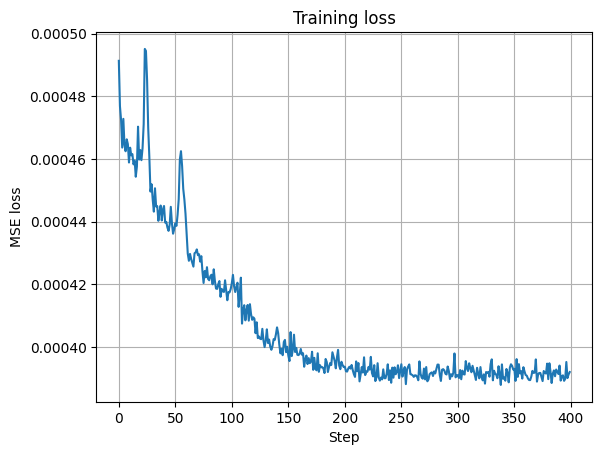

In [26]:
#Zoom in
plt.plot(epoch_losses[100:]) #We remove the first 18000 steps to better visualize the trend
plt.xlabel("Step")
plt.ylabel("MSE loss")
plt.title("Training loss")
plt.grid()
plt.show()

## Test

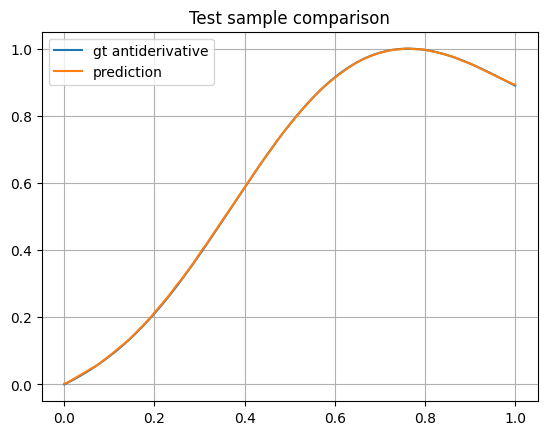

In [38]:
model.eval()
with torch.no_grad():
    sample_idx = 10
    model_dev = next(model.parameters()).device  # cuda/cpu of the model

    # ---- branch sample (keep batch dim) ----
    xb_s = Xb_test[sample_idx:sample_idx+1].to(model_dev, non_blocking=True)  # (1, F)

    # ---- trunk sample (handle 2D or 3D, keep batch dim) ----
    if Xt_test.dim() == 2:  # (N,1)
        xt_s = Xt_test.unsqueeze(0).to(model_dev, non_blocking=True)          # (1, N, 1)
    elif Xt_test.dim() == 3:  # (B,N,1)
        xt_s = Xt_test[sample_idx:sample_idx+1].to(model_dev, non_blocking=True)  # (1, N, 1)
    else:
        raise RuntimeError(f"Unexpected Xt_test.dim()={Xt_test.dim()}")

    # ---- forward ----
    y_pred = model(xb_s, xt_s)          # (1, N, 1)
    y_pred_np = y_pred[0, :, 0].cpu().numpy()

    # ---- ground truth (ensure shape (N,)) ----
    y_gt = Y_test[sample_idx]
    if y_gt.dim() == 2:   # (N,1)
        y_gt_np = y_gt[:, 0].cpu().numpy()
    elif y_gt.dim() == 1: # (N,)
        y_gt_np = y_gt.cpu().numpy()
    else:
        y_gt_np = y_gt.squeeze().cpu().numpy()

    # ---- x-grid from trunk ----
    xgrid = xt_s[0, :, 0].detach().cpu().numpy()

    plt.plot(xgrid, y_gt_np, label="gt antiderivative")
    plt.plot(xgrid, y_pred_np, label="prediction")
    plt.title("Test sample comparison")
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
import numpy as np
import torch

def normalized_l2_error(pred, ref):
    # pred/ref: (...,)
    diff = pred - ref
    diff_norm = torch.linalg.vector_norm(diff)
    ref_norm  = torch.linalg.vector_norm(ref)
    return (diff_norm / ref_norm).item()

model.eval()
with torch.no_grad():
    dev = next(model.parameters()).device

    # Move whole test set to the model's device
    xb = Xb_test.to(dev, non_blocking=True)               # (B, F)
    xt = Xt_test.to(dev, non_blocking=True)               # (N,1) or (B,N,1) — model will expand if needed
    y  = Y_test.to(dev, non_blocking=True)                # (B, N, 1) (or (B,N) if that’s your variant)

    # Forward once over the full test set
    pred = model(xb, xt)                                  # (B, N, 1)

    # Ensure both tensors are 2D (B, N) for error computation
    pred2 = pred.view(pred.size(0), -1)                   # (B, N)
    y2    = y.view(y.size(0), -1)                         # (B, N)

    # Vectorized normalized L2 per-sample
    num   = torch.linalg.vector_norm(pred2 - y2, dim=1)   # (B,)
    denom = torch.linalg.vector_norm(y2, dim=1).clamp_min(1e-12)
    errs  = (num / denom)                                 # (B,)

    mean_err = errs.mean().item()
    std_err  = errs.std(unbiased=False).item()

print(
    "Normalized L2 error over the test set (per-sample aggregation):\n"
    f"  mean = {mean_err:.6f}  ({mean_err*100:.2f}%)\n"
    f"  std  = {std_err:.6f}  ({std_err*100:.2f}%)\n"
    "Interpretation: 0 is perfect; 0.10 ≈ 10% relative error. Lower is better."
)

Normalized L2 error over the test set (per-sample aggregation):
  mean = 0.011402  (1.14%)
  std  = 0.028998  (2.90%)
Interpretation: 0 is perfect; 0.10 ≈ 10% relative error. Lower is better.


## Test: predict new data

In [40]:
# ========= Evaluation config =========
data_path    = "E:/progetti/NNDL/Datasets/antiderivative_aligned_data.npz"   # or ..._test.npz / ..._train.npz
weights_path = "deeponet.pt"                       # your saved model state_dict

"""
# Must match the trained model:
in_size_branch = 100
width_size     = 40
depth          = 1
interact_size  = 40

# What to plot
plot_sample_indices = [0, 1, 2]

# Device preference: CUDA > MPS (Apple Silicon) > CPU
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device
"""


'\n# Must match the trained model:\nin_size_branch = 100\nwidth_size     = 40\ndepth          = 1\ninteract_size  = 40\n\n# What to plot\nplot_sample_indices = [0, 1, 2]\n\n# Device preference: CUDA > MPS (Apple Silicon) > CPU\nimport torch\nif torch.cuda.is_available():\n    device = torch.device("cuda")\nelif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():\n    device = torch.device("mps")\nelse:\n    device = torch.device("cpu")\ndevice\n'

In [41]:
import numpy as np

npz = np.load(data_path, allow_pickle=True)
branch_inputs = npz["X"][0]    # (B, P)
trunk_inputs  = npz["X"][1]    # (N, 1) shared grid
y_true        = npz["y"]       # (B, N) or (B, N, 1)

print("Loaded shapes:", branch_inputs.shape, trunk_inputs.shape, y_true.shape)

# Ensure y_true is (B, N, 1)
if y_true.ndim == 2:
    y_true = y_true[..., None]
elif y_true.ndim == 3 and y_true.shape[-1] == 1:
    pass
else:
    raise ValueError(f"Unexpected y shape: {y_true.shape}")

import torch
Xb = torch.tensor(branch_inputs, dtype=torch.float32, device=device)   # (B, P)
Xt = torch.tensor(trunk_inputs,  dtype=torch.float32, device=device)   # (N, 1)
Y  = torch.tensor(y_true,        dtype=torch.float32, device=device)   # (B, N, 1)

# Expand shared trunk grid to batch: (B, N, 1)
Xt_batch = Xt.unsqueeze(0).expand(Xb.shape[0], -1, -1)


Loaded shapes: (150, 1000) (1000, 1) (150, 1000)


In [42]:
print("Xb shape:", Xb.shape)         # should be (B, P) only
print("Xt shape:", Xt.shape)         # (N, 1)
try:
    print("Xt_batch shape:", Xt_batch.shape)  # (B, N, 1)
except NameError:
    pass

# What the trained model expects
branch_in_expected = model.branch_net.net[0].in_features
trunk_in_expected  = model.trunk_net.net[0].in_features
print("Model expects: branch_in =", branch_in_expected, "  trunk_in =", trunk_in_expected)

# If you previously did something like: Xb = Xb.unsqueeze(1).expand(B,N,P) — undo it.
if Xb.ndim > 2:
    # collapse any extra dims except the last one (features)
    Xb = Xb.view(Xb.shape[0], -1)  # but better: rebuild from the original branch_inputs array
    print("Fixed Xb to shape:", Xb.shape)

# Xt should be shared grid: (N,1)
# Build Xt_batch for the model call as (B,N,1), but DO NOT touch Xb
Xt_batch = Xt.unsqueeze(0).expand(Xb.shape[0], -1, -1)
print("Xt_batch shape:", Xt_batch.shape)

import numpy as np
import torch

P_data = Xb.shape[1]
P_tgt  = branch_in_expected

if P_data != P_tgt:
    # assume branch and trunk share the same interval; infer from Xt
    a = float(Xt[0,0].cpu().item())
    b = float(Xt[-1,0].cpu().item())
    x_src = np.linspace(a, b, P_data)
    x_tgt = np.linspace(a, b, P_tgt)

    Xb_np = Xb.detach().cpu().numpy()
    Xb_rs = np.stack([np.interp(x_tgt, x_src, row) for row in Xb_np], axis=0)  # (B, P_tgt)
    Xb = torch.tensor(Xb_rs, dtype=torch.float32, device=Xb.device)
    print(f"Resampled branch from P={P_data} -> P={P_tgt}")


Xb shape: torch.Size([150, 1000])
Xt shape: torch.Size([1000, 1])
Xt_batch shape: torch.Size([150, 1000, 1])
Model expects: branch_in = 1000   trunk_in = 1
Xt_batch shape: torch.Size([150, 1000, 1])


In [43]:
import torch

def normalized_l2_error(pred, ref):
    diff = pred - ref
    diff_norm = torch.linalg.vector_norm(diff)
    ref_norm  = torch.linalg.vector_norm(ref)
    return (diff_norm / (ref_norm + 1e-12)).item()

with torch.no_grad():
    Y_pred = model(Xb, Xt_batch)   # (B, N, 1)

B, N, _ = Y.shape
errs, mses = [], []
for i in range(B):
    errs.append(normalized_l2_error(Y_pred[i].view(-1), Y[i].view(-1)))
    mses.append(torch.mean((Y_pred[i] - Y[i])**2).item())

import numpy as np
print(f"Mean norm L2 error: {np.mean(errs):.6e}  (std {np.std(errs):.6e})")
print(f"Mean MSE:           {np.mean(mses):.6e}  (std {np.std(mses):.6e})")

Mean norm L2 error: 5.632384e-02  (std 3.641131e-02)
Mean MSE:           1.179841e-05  (std 9.026886e-06)


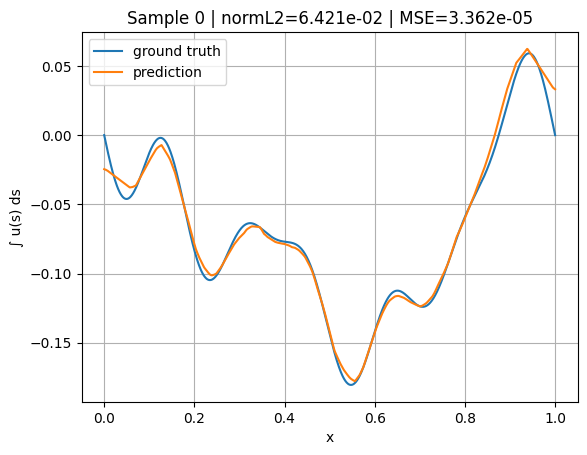

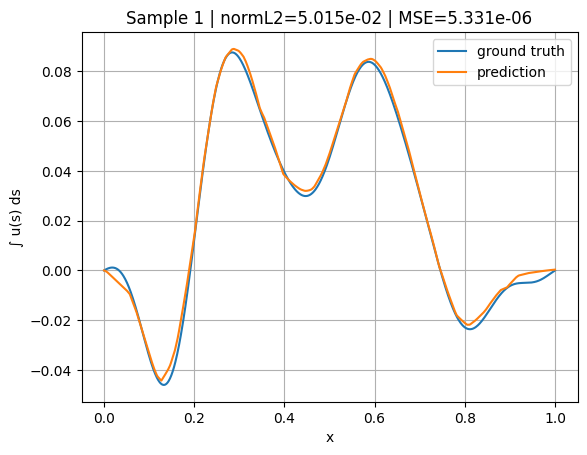

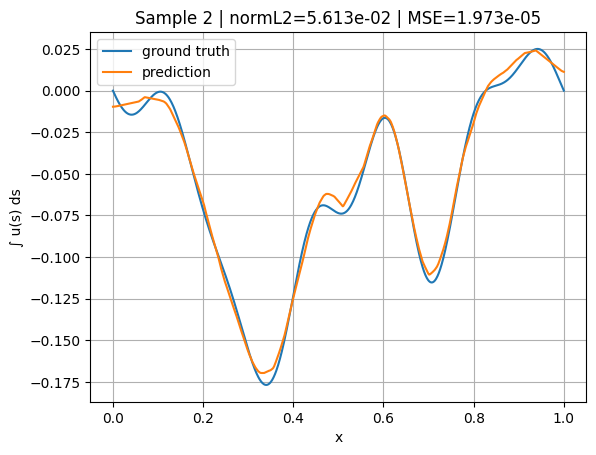

In [44]:
import matplotlib.pyplot as plt

xgrid = Xt[:, 0].detach().cpu().numpy()  # (N,)

plot_sample_indices = [0, 1, 2]

for idx in plot_sample_indices:
    if not (0 <= idx < B):
        continue
    y_gt  = Y[idx, :, 0].detach().cpu().numpy()
    y_hat = Y_pred[idx, :, 0].detach().cpu().numpy()
    plt.figure()
    plt.plot(xgrid, y_gt,  label="ground truth")
    plt.plot(xgrid, y_hat, label="prediction")
    plt.title(f"Sample {idx} | normL2={errs[idx]:.3e} | MSE={mses[idx]:.3e}")
    plt.xlabel("x"); plt.ylabel("∫ u(s) ds")
    plt.grid(); plt.legend()
    plt.show()


### Trial (normalization)

Loaded shapes: (150, 1000) (1000, 1) (150, 1000)
Mean norm L2 error: 3.381409e-01  (std 1.834158e-01)
Mean MSE:           1.097945e-03  (std 2.040712e-03)


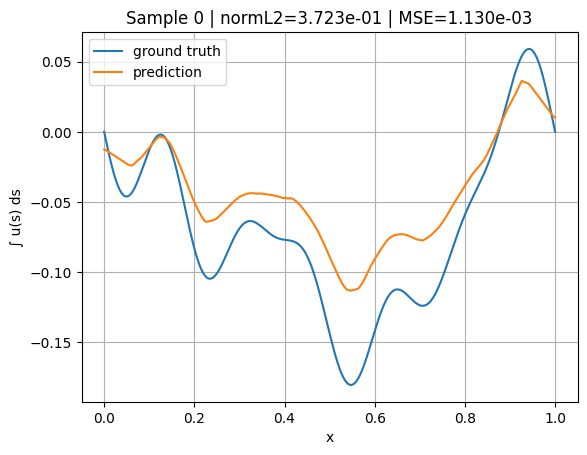

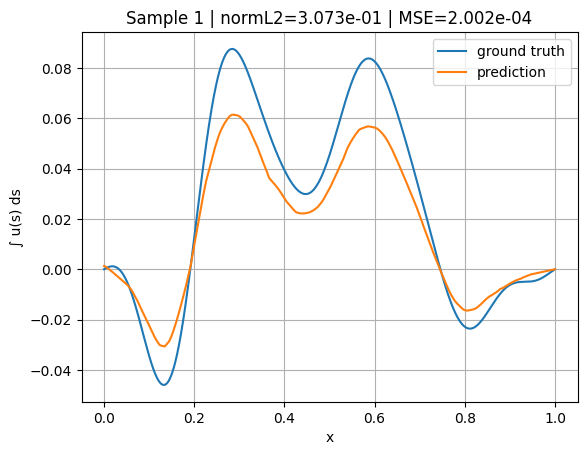

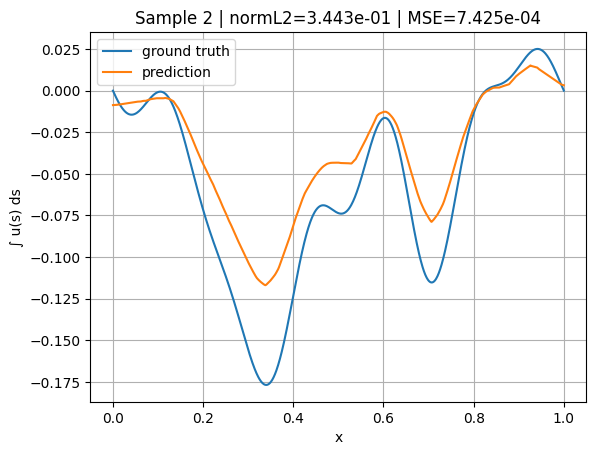

In [150]:
# ========= Evaluation config =========
data_path    = "antiderivative_aligned_data.npz"   # or ..._test.npz / ..._train.npz
weights_path = "deeponet.pt"

import numpy as np
import torch
import matplotlib.pyplot as plt

# -- Load dataset
npz = np.load(data_path, allow_pickle=True)
branch_inputs = npz["X"][0]    # (B, P)
trunk_inputs  = npz["X"][1]    # (N, 1) shared grid
y_true        = npz["y"]       # (B, N) or (B, N, 1)

print("Loaded shapes:", branch_inputs.shape, trunk_inputs.shape, y_true.shape)

# Ensure y_true has shape (B, N, 1)
if y_true.ndim == 2:
    y_true = y_true[..., None]
elif not (y_true.ndim == 3 and y_true.shape[-1] == 1):
    raise ValueError(f"Unexpected y shape: {y_true.shape}")

# ----- Normalize ONLY the input functions (branch) -----
# per-sample normalization by max|u|
eps = 1e-12
amp_branch = np.maximum(np.max(np.abs(branch_inputs), axis=1, keepdims=True), eps)
branch_inputs_norm = branch_inputs / amp_branch

# ----- Tensors -----
Xb = torch.tensor(branch_inputs_norm, dtype=torch.float32, device=device)  # normalized input (B,P)
Xt = torch.tensor(trunk_inputs,        dtype=torch.float32, device=device)  # (N,1)
Y  = torch.tensor(y_true,              dtype=torch.float32, device=device)  # ground truth (B,N,1)

# Expand shared trunk grid to batch: (B,N,1)
Xt_batch = Xt.unsqueeze(0).expand(Xb.shape[0], -1, -1)

# Resample branch if needed
branch_in_expected = model.branch_net.net[0].in_features
if Xb.shape[1] != branch_in_expected:
    a = float(Xt[0,0].detach().cpu().item())
    b = float(Xt[-1,0].detach().cpu().item())
    x_src = np.linspace(a, b, Xb.shape[1])
    x_tgt = np.linspace(a, b, branch_in_expected)
    Xb_np = Xb.detach().cpu().numpy()
    Xb_rs = np.stack([np.interp(x_tgt, x_src, row) for row in Xb_np], axis=0)  # (B, P_target)
    Xb = torch.tensor(Xb_rs, dtype=torch.float32, device=Xb.device)
    print(f"[EVAL] Resampled branch P: {Xb_np.shape[1]} -> {branch_in_expected}")

# ----- Inference (outputs are NOT normalized) -----
with torch.no_grad():
    Y_pred = model(Xb, Xt_batch)   # (B,N,1)

# ----- Metrics -----
def normalized_l2_error(pred, ref):
    diff = pred - ref
    diff_norm = torch.linalg.vector_norm(diff)
    ref_norm  = torch.linalg.vector_norm(ref)
    return (diff_norm / (ref_norm + 1e-12)).item()

B, N, _ = Y.shape
errs, mses = [], []
for i in range(B):
    errs.append(normalized_l2_error(Y_pred[i].view(-1), Y[i].view(-1)))
    mses.append(torch.mean((Y_pred[i] - Y[i])**2).item())

print(f"Mean norm L2 error: {np.mean(errs):.6e}  (std {np.std(errs):.6e})")
print(f"Mean MSE:           {np.mean(mses):.6e}  (std {np.std(mses):.6e})")

# ----- Plot -----
xgrid = Xt[:, 0].detach().cpu().numpy()
plot_sample_indices = [0, 1, 2]

for idx in plot_sample_indices:
    if not (0 <= idx < B):
        continue
    y_gt  = Y[idx, :, 0].detach().cpu().numpy()
    y_hat = Y_pred[idx, :, 0].detach().cpu().numpy()
    plt.figure()
    plt.plot(xgrid, y_gt,  label="ground truth")
    plt.plot(xgrid, y_hat, label="prediction")
    plt.title(f"Sample {idx} | normL2={errs[idx]:.3e} | MSE={mses[idx]:.3e}")
    plt.xlabel("x"); plt.ylabel("∫ u(s) ds")
    plt.grid(); plt.legend()
    plt.show()